In [1]:
import itertools
import random
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from seaborn import heatmap

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)

In [3]:
# Load final exam and assignment data
data = pd.DataFrame(columns=['SubjectID', 'Assignment', 'CodeStateID'])
grades = {}
scores = {}
total_non_compile = 0
data_dir = Path.cwd() / 'data'
for directory in [data_dir / 'F19_All' / 'Train', data_dir / 'S19_All']:
    grade_data = pd.read_csv(directory / 'Data' / 'LinkTables' / 'Subject.csv')
    for row in grade_data.itertuples():
        grades[row.SubjectID] = row._2 if directory.name == 'S19_All' else row._2 / 100
    main = pd.read_csv(directory / 'Data' / 'MainTable.csv')
    total_non_compile += len(main['CodeStateID'].unique())
    for row in main[main['EventType'] == 'Run.Program'].itertuples():
        scores[row.CodeStateID] = row.Score
    main['Assignment'] = [f'{int(x[0])}-{int(x[1])}' for x in list(zip(main['AssignmentID'], main['ProblemID']))]
    data = pd.concat([data, main[['SubjectID', 'Assignment', 'CodeStateID']]], ignore_index=True)

data['Score'] = [scores[x] for x in data['CodeStateID']]
data['ExamGrade'] = [grades[x] if x in grades else 0 for x in data['SubjectID']]
data = data[data['Score'] == 1]
data.head()

,SubjectID,Assignment,CodeStateID,Score,ExamGrade
0,014604ba54339d4b1266cf78e125053a5ac11dd861ef3cc0b4ed777ed0e2af0a,439-1,79c9e2da9bc703116d8768297056db22866c43d583e529d73bf25235f1ca6b16,1.0,0.97
1,014604ba54339d4b1266cf78e125053a5ac11dd861ef3cc0b4ed777ed0e2af0a,439-1,79c9e2da9bc703116d8768297056db22866c43d583e529d73bf25235f1ca6b16,1.0,0.97
2,014604ba54339d4b1266cf78e125053a5ac11dd861ef3cc0b4ed777ed0e2af0a,439-3,0e91ae5696da0d6a724380360147b8699a25c14ff4622713875f92127b52737b,1.0,0.97
3,014604ba54339d4b1266cf78e125053a5ac11dd861ef3cc0b4ed777ed0e2af0a,439-3,0e91ae5696da0d6a724380360147b8699a25c14ff4622713875f92127b52737b,1.0,0.97
4,014604ba54339d4b1266cf78e125053a5ac11dd861ef3cc0b4ed777ed0e2af0a,439-5,1b38c7b1c7ebca281bbbc270d1b896484de663045c715fd4ec54ab6b36859106,1.0,0.97


In [4]:
random.seed(1)
code_ids = data['CodeStateID']
assignments = data['Assignment']
assign_c = {}
unique_assignments = data['Assignment'].unique()
for assign in unique_assignments:
    assign_c[assign] = (random.random(), random.random(), random.random())
assign_lookup = {}
for c_id, assign in zip(code_ids, assignments):
    assign_lookup[c_id] = assign

In [5]:
embedding_vectors = [
    ('code2vec', 384, ''),
    ('tf_idf', 50, ''),
    ('deepwalk', 50, ''),
    ('node2vec', 50, '')
]

embedding_methods = ['deepwalk', 'node2vec']
cstrats = [(f'{strat}Canonicalization', '') for strat in ['full', 'none', 'orig', 'part']]
cstrats.extend((f'{strat}C-', f'{strat}C-') for strat in ['F', 'L', 'N', 'V'])
embedding_vectors.extend((f'{strat}{method}', 50, lstr) for method, (strat, lstr) in itertools.product(embedding_methods, cstrats))
embedding_vectors

[('code2vec', 384, ''),
 ('tf_idf', 50, ''),
 ('deepwalk', 50, ''),
 ('node2vec', 50, ''),
 ('fullCanonicalizationdeepwalk', 50, ''),
 ('noneCanonicalizationdeepwalk', 50, ''),
 ('origCanonicalizationdeepwalk', 50, ''),
 ('partCanonicalizationdeepwalk', 50, ''),
 ('FC-deepwalk', 50, 'FC-'),
 ('LC-deepwalk', 50, 'LC-'),
 ('NC-deepwalk', 50, 'NC-'),
 ('VC-deepwalk', 50, 'VC-'),
 ('fullCanonicalizationnode2vec', 50, ''),
 ('noneCanonicalizationnode2vec', 50, ''),
 ('origCanonicalizationnode2vec', 50, ''),
 ('partCanonicalizationnode2vec', 50, ''),
 ('FC-node2vec', 50, 'FC-'),
 ('LC-node2vec', 50, 'LC-'),
 ('NC-node2vec', 50, 'NC-'),
 ('VC-node2vec', 50, 'VC-')]

In [7]:
vector_dir = Path.cwd() / 'data' / 'Vectors'
vector_files = [(vector_dir / f'{f}.csv', s, l) for f, s, l in embedding_vectors]

In [8]:
def get_distance_summary(dist_groups: dict):
    print("Distance Summary")
    dist_df = pd.DataFrame.from_dict(dist_groups)
    dist_df = dist_df.T
    dist_df = (dist_df - dist_df.min()) / (dist_df.max() - dist_df.min())
    dist_df = dist_df.T
    return dist_df.describe().T.sort_index()


how_similar = {
    (1, 2): 'similar',
    (1, 3): 'dissimilar',
    (1, 4): 'dissimilar',
    (2, 3): 'dissimilar',
    (2, 4): 'dissimilar',
    (3, 4): 'similar'
}

ex_map = {
    '487-20': 1,
    '439-236': 2,
    '439-232': 3,
    '439-234': 4
}


def get_dist_group_name(p1, p2):
    p1 = ex_map[p1]
    p2 = ex_map[p2]
    if p1 == p2:
        return f'same_{p1}'
    s1, s2 = sorted([p1, p2])
    return f'{how_similar[(s1, s2)]}_{p1}-{p2}'


def add_to_dist_groups(groups, dist, p1, p2):
    group_name = get_dist_group_name(p1, p2)
    if group_name not in groups:
        groups[group_name] = []
    groups[group_name].append(dist)

# TODO: Discuss how we generate the heatmap distances

In [12]:
def heat_map(frame, vector_size, output, lstr):
    PROBLEMS = ['439-236', '487-20', '439-232', '439-234']
    random.seed(1)
    vector_map = {}
    vectors = np.array(frame.iloc[:, 0:vector_size])
    c_ids = frame['CodeStateID']
    for v, c in zip(vectors, c_ids):
        vector_map[c[len(lstr):]] = v
    filt = data[[x in vector_map for x in data['CodeStateID']]]
    chosen_ids = []
    for problem in PROBLEMS:
        filt2 = filt[filt['Assignment'] == problem].reset_index()
        chosen_ids += random.sample(list(filt2['CodeStateID']), 10)
    chosen_vectors = [vector_map[x] for x in chosen_ids]
    distances = np.zeros((len(chosen_vectors), len(chosen_vectors)))
    dist_groups = {}
    problems = [p for p in itertools.chain.from_iterable([[p] * 10 for p in PROBLEMS])]
    for p1_index, p1 in enumerate(problems):
        for p2_index, p2 in enumerate(problems):
            dist = np.linalg.norm(chosen_vectors[p1_index] - chosen_vectors[p2_index])
            add_to_dist_groups(dist_groups, dist, p1, p2)
            distances[p1_index][p2_index] = dist
            distances[p2_index][p1_index] = dist
    print(get_distance_summary(dist_groups))
    heatmap(distances)
    print(output)
    plt.savefig(output)
    plt.clf()

# TODO: Discuss why this is an ideal heat map

Ideal heat map


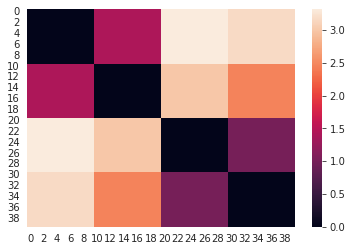

In [10]:
print("Ideal heat map")
vectors = []
distances = np.zeros((40, 40))
for i in range(10):
    vectors.append(np.array([0, 1, 1]))
for i in range(10):
    vectors.append(np.array([1, 2, 1]))
for i in range(10):
    vectors.append(np.array([3, 0, 0]))
for i in range(10):
    vectors.append(np.array([3, 1, 0]))
for i in range(len(vectors)):
    for j in range(i, len(vectors)):
        dist = np.linalg.norm(vectors[i] - vectors[j])
        distances[i][j] = dist
        distances[j][i] = dist
heatmap(distances)
plt.show()

In [13]:
heatmap_dir = data_dir / 'Images' / 'heatmaps'
heatmap_dir.mkdir(parents=True, exist_ok=True)
for file, size, lstr in vector_files:
    print()
    print(file.stem)
    heat_map(pd.read_csv(file), size, heatmap_dir / f'{file.stem}.png', lstr)


code2vec
Distance Summary
                count      mean       std       min       25%       50%       75%       max
dissimilar_1-3  100.0  0.880234  0.085547  0.602185  0.832658  0.903266  0.943112  0.997453
dissimilar_1-4  100.0  0.920379  0.088515  0.706778  0.844130  0.957955  1.000000  1.000000
dissimilar_2-3  100.0  0.909770  0.061258  0.759085  0.869128  0.910980  0.956155  1.000000
dissimilar_2-4  100.0  0.901364  0.050679  0.794648  0.864032  0.897367  0.931879  1.000000
dissimilar_3-1  100.0  0.880234  0.085547  0.602185  0.832658  0.903266  0.943112  0.997453
dissimilar_3-2  100.0  0.909770  0.061258  0.759085  0.869128  0.910980  0.956155  1.000000
dissimilar_4-1  100.0  0.920379  0.088515  0.706778  0.844130  0.957955  1.000000  1.000000
dissimilar_4-2  100.0  0.901364  0.050679  0.794648  0.864032  0.897367  0.931879  1.000000
same_1          100.0  0.217939  0.137123  0.000000  0.117459  0.222085  0.324113  0.464224
same_2          100.0  0.086237  0.074617  0.000000  

<Figure size 432x288 with 0 Axes>

Useful regex to extract results to table `(.*?)\s+([\d\.]+)?(NaN)?\s+([\d\.]+)?(NaN)?\s+(\(.*\))?(NaN)?`

In [ ]:
foo = "12345"
bar = "12"
foo[len(bar):]